# Prediction of Flight Delay using Random Forests (Scikit Learn)
The data used in this project can be downloaded from https://www.transtats.bts.gov/Fields.asp

In [103]:
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn import metrics
import matplotlib.pylab as plt
warnings.filterwarnings('ignore')
plt.rcParams["figure.figsize"] = (20,10)
df = pd.read_csv("Data_jan_2018.csv")

After inspecting the dataframe, I decided to remove the following columns because of missing values:

    - Unnamed: 37

    - SCH_OP_CARRIER
    
    - SCH_OP_UNIQUE_CARRIER 
    
    - SCH_OP_CARRIER_FL_NUM
    
    - SCH_OP_CARRIER_AIRLINE_ID 

In [104]:
df.info()
df=df.drop(['SCH_OP_UNIQUE_CARRIER', 'SCH_OP_CARRIER_AIRLINE_ID','SCH_OP_CARRIER','SCH_OP_CARRIER_FL_NUM','Unnamed: 37'], axis=1)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 621461 entries, 0 to 621460
Data columns (total 38 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   YEAR                       621461 non-null  int64  
 1   DAY_OF_WEEK                621461 non-null  int64  
 2   FL_DATE                    621461 non-null  object 
 3   MKT_UNIQUE_CARRIER         621461 non-null  object 
 4   BRANDED_CODE_SHARE         621461 non-null  object 
 5   MKT_CARRIER_AIRLINE_ID     621461 non-null  int64  
 6   MKT_CARRIER                621461 non-null  object 
 7   MKT_CARRIER_FL_NUM         621461 non-null  int64  
 8   SCH_OP_UNIQUE_CARRIER      160 non-null     object 
 9   SCH_OP_CARRIER_AIRLINE_ID  160 non-null     float64
 10  SCH_OP_CARRIER             160 non-null     object 
 11  SCH_OP_CARRIER_FL_NUM      160 non-null     float64
 12  OP_UNIQUE_CARRIER          621461 non-null  object 
 13  OP_CARRIER_AIRLINE_ID      62

We will inspect other categorical variables to decide if they are relevant. We notice that Flights and Cancelled have very poor distributions that are unlikely to be relevant.

In [105]:
print(f'FLIGHTS Coulumn:\n{df["FLIGHTS"].value_counts()} \n')
print(f'CANCELLED Coulumn:\n{df["CANCELLED"].value_counts()} \n')
print(f'MKT_CARRIER Coulumn:\n{df["MKT_CARRIER"].value_counts()} \n')
print(f'BRANDED_CODE_SHARE Coulumn:\n{df["BRANDED_CODE_SHARE"].value_counts()} \n')

FLIGHTS Coulumn:
1.0    621461
Name: FLIGHTS, dtype: int64 

CANCELLED Coulumn:
0.0    602485
1.0     18976
Name: CANCELLED, dtype: int64 

MKT_CARRIER Coulumn:
AA    163773
DL    133374
UA    116919
WN    109676
AS     28797
B6     24871
NK     14180
F9      9707
HA      7526
G4      6814
VX      5824
Name: MKT_CARRIER, dtype: int64 

BRANDED_CODE_SHARE Coulumn:
WN              109676
AA_CODESHARE     90175
AA               73598
UA_CODESHARE     71535
DL               71254
DL_CODESHARE     62120
UA               45384
B6               24871
AS               15312
NK               14180
AS_CODESHARE     13485
F9                9707
G4                6814
HA                6627
VX                5824
HA_CODESHARE       899
Name: BRANDED_CODE_SHARE, dtype: int64 



## Cancelled flights make up about 3% of the dataset.

Percentage of cancelled flights 3.053449854455871%


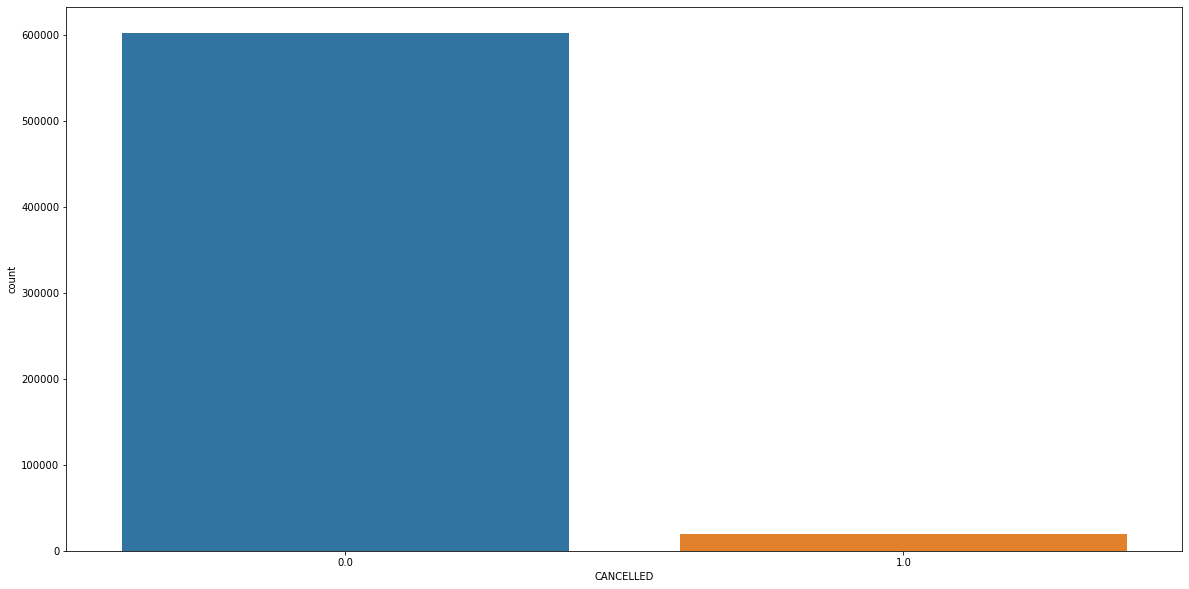

In [106]:
CANCELLED_count = len(df[df['CANCELLED']==1])
pct_of_CANCELLED = CANCELLED_count/(len(df.CANCELLED))
print(f"Percentage of cancelled flights {pct_of_CANCELLED*100}%")
ax = sns.countplot(data = df, x = 'CANCELLED')

# we can see that some carriers are more prone to delays than others

By comparing the two following plots, The first representing flights that are 15 minutes or more late and the second showing on-time flights for each carrier.

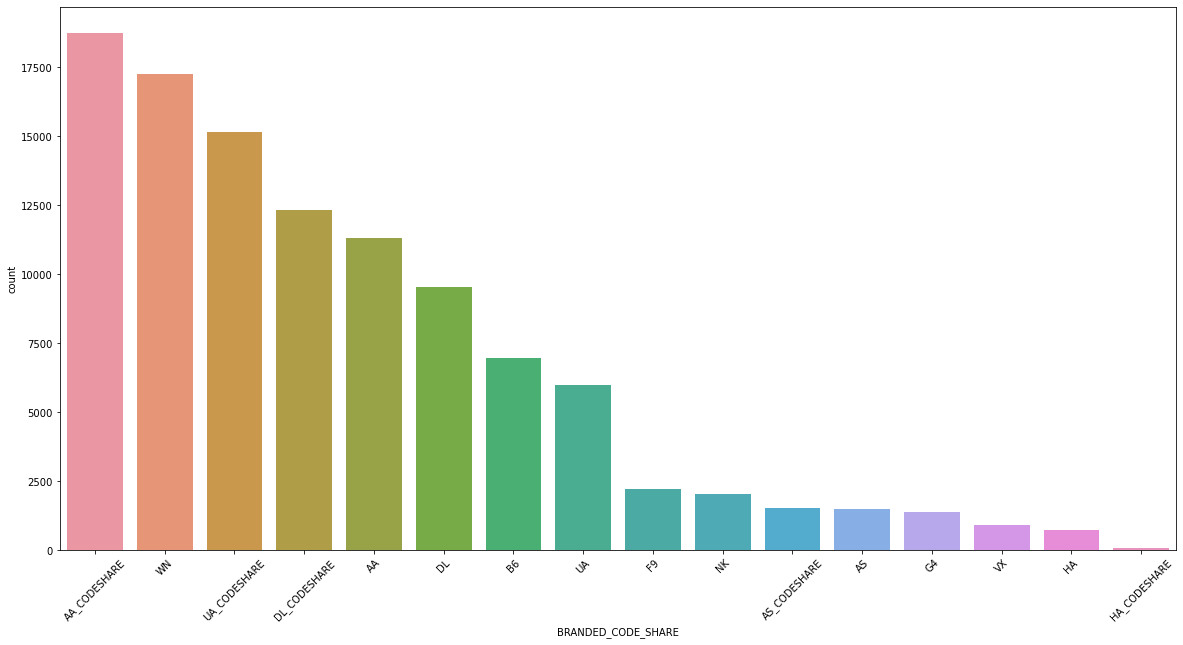

In [107]:
delayed_flights = df[df.ARR_DEL15 == 1]
ax = sns.countplot(data = delayed_flights, x = 'BRANDED_CODE_SHARE', order = delayed_flights['BRANDED_CODE_SHARE'].value_counts().index)
ticks = ax.set_xticklabels(ax.get_xticklabels(),rotation=45)

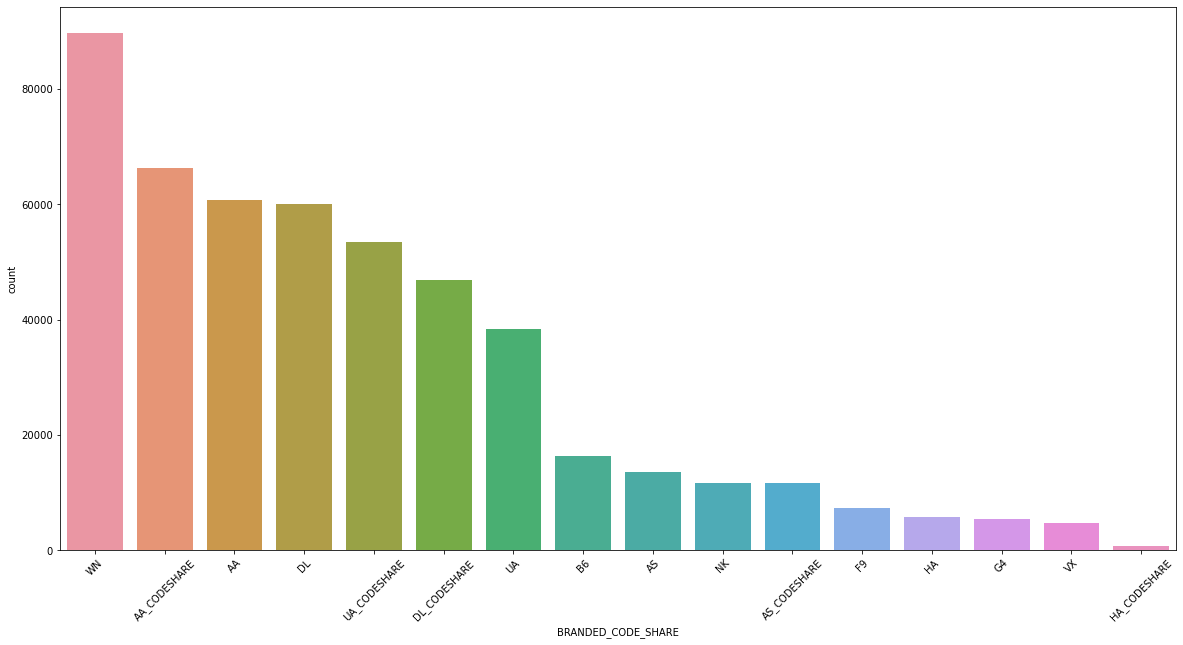

In [108]:
nondelayed_flights = df[df.ARR_DEL15 == 0]
ax = sns.countplot(data = nondelayed_flights, x = 'BRANDED_CODE_SHARE', order = nondelayed_flights['BRANDED_CODE_SHARE'].value_counts().index)
ticks = ax.set_xticklabels(ax.get_xticklabels(),rotation=45)

## We will calculate the ratio of cancelled flights for each carrier

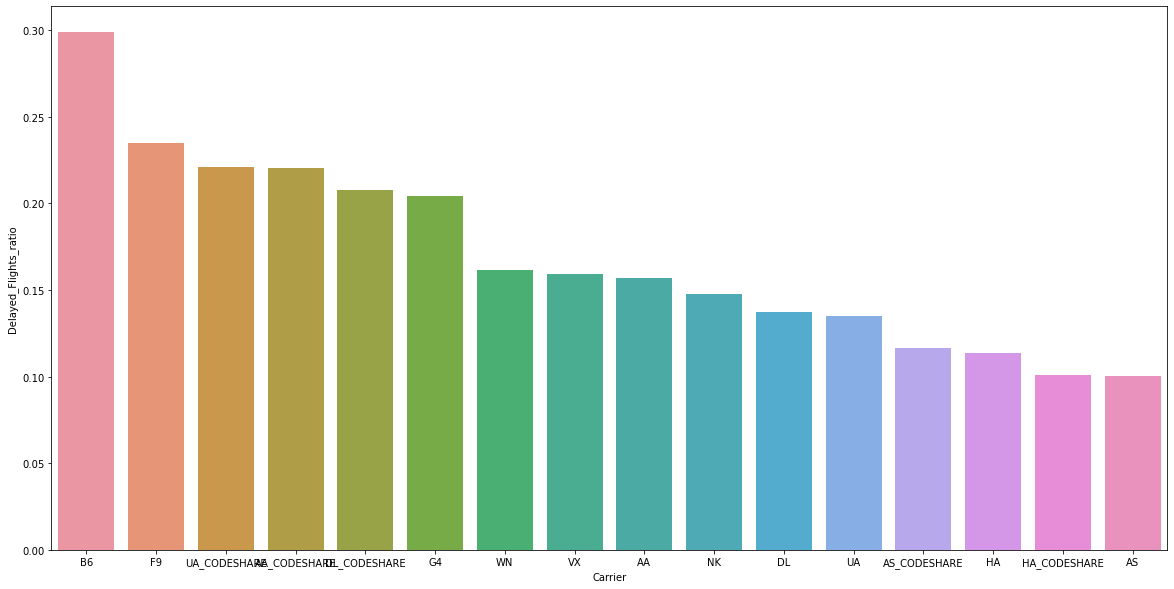

In [109]:
df_delayed_flights = df[df.ARR_DEL15 == 1].groupby('BRANDED_CODE_SHARE').agg({'FLIGHTS':'count'}).reset_index()
df_delayed_flights.columns = ['Carrier', 'Delayed_Flights']
df_on_time_flights = df[df.ARR_DEL15 == 0].groupby('BRANDED_CODE_SHARE').agg({'FLIGHTS':'count'}).reset_index()
df_on_time_flights.columns = ['Carrier', 'On_Time_Flights']
df_delays = df_delayed_flights.merge(df_on_time_flights)
df_delays['Delayed_Flights_ratio'] = df_delays['Delayed_Flights']/(df_delays['Delayed_Flights'] + df_delays['On_Time_Flights'])
df_delays = df_delays.sort_values(by=['Delayed_Flights_ratio'], ascending=False)
sns.barplot(data=df_delays, x='Carrier', y = 'Delayed_Flights_ratio')

## Naturally, there's a very high correlation between arrival delays and departure delays. but we can't use departure delays as a feature because we won't have this information if we need to make a prediction about a future flight.

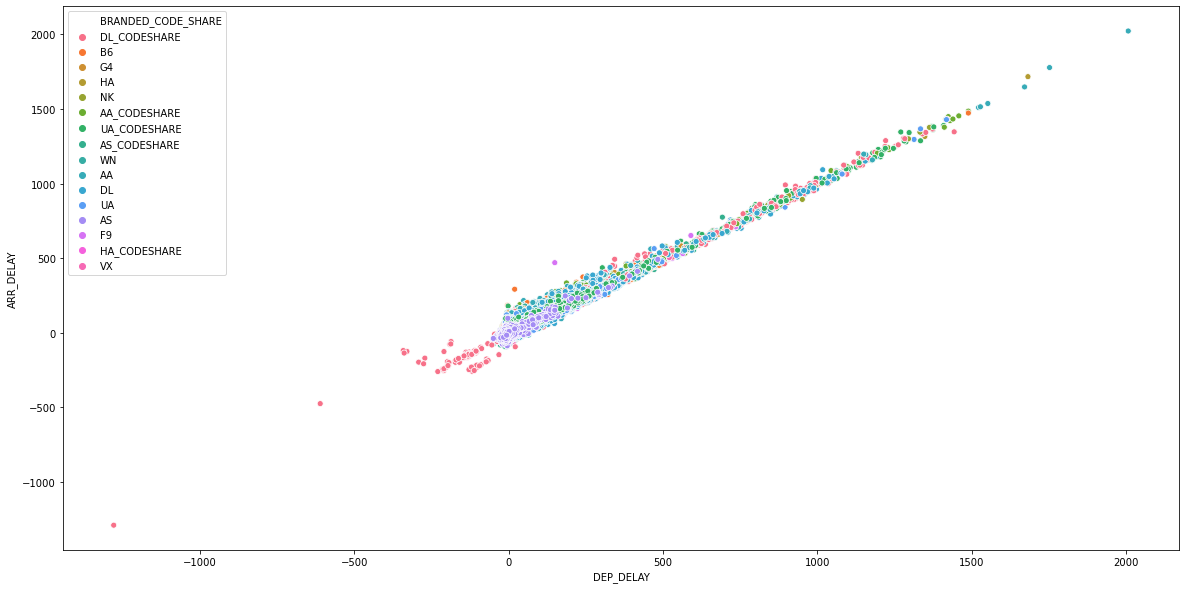

In [110]:
sns.scatterplot(data=df, y="ARR_DELAY",x="DEP_DELAY",hue="BRANDED_CODE_SHARE")

## Below is the correlation matrix for all available features
Notice the correlation between DEP_DELAY, DEP_DELAY_NEW, DEP_DEL15, DEP_DELAY_GROUP, ARR_DELAY, ARR_DELAY_NEW, ARR_DEL15, and ARR_DELAY_GROUP

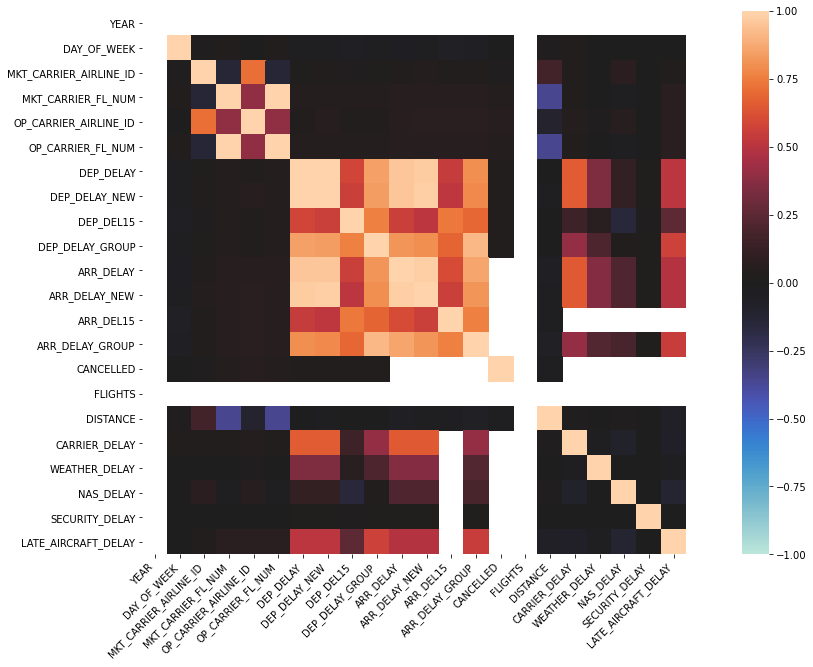

In [111]:
corr=df.corr()
ax = sns.heatmap(corr, 
    vmin=-1, vmax=1, center=0,
    square=True)
ticks = ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')

## As discussed, departure delay features can be used. As are arrival delay features, only one of them can be the target feature
## The delay resons features CARRIER_DELAY, WEATHER_DELAY, NAS_DELAY, SECURITY_DELAY, and LATE_AIRCRAFT_DELAY can't be used because we have no way to tell that one of these reasons will occur in a future flight.
However it's possible to use weather reports when predicting future flight delay. We will engineer a new feature called WEATHER_GROUP which is a rating for the weather on a given day from 0 to 4, the higher the worse.
This is achieved by aggregating the mean WEATHER_DELAY by day accross all flights, calculating the .2, .4, .6, .8, 1 quantiles for these values and using these quantiles as cutoff values to determine the WEATHER_GROUP

In [112]:
weather_df = df.groupby('FL_DATE').agg({'WEATHER_DELAY':'mean'}).reset_index()
weather_dict = {}
for weather_group, quantile in enumerate(np.arange(0.2, 1.01, .2)):
    weather_dict[weather_group] = np.quantile(weather_df.WEATHER_DELAY, quantile)
weather_dict

{0: 1.6638576779026217,
 1: 2.4307098020280056,
 2: 4.502068252326784,
 3: 5.293251533742331,
 4: 16.381821197545197}

In [113]:
weather_df['WEATHER_GROUP'] = 0
for index, row in weather_df.iterrows():
    for weather_group in range(0,5):
        if row['WEATHER_DELAY'] < weather_dict[weather_group]:
            weather_df.loc[index, 'WEATHER_GROUP'] = weather_group
            break
        if weather_group == 4:
            weather_df.loc[index, 'WEATHER_GROUP'] = 4

weather_df['WEATHER_GROUP'].value_counts()

4    7
3    6
2    6
1    6
0    6
Name: WEATHER_GROUP, dtype: int64

In [114]:
weather_df = weather_df.drop(['WEATHER_DELAY'], axis=1)
df = df.merge(weather_df)

## We will remove all irrelevant categorical variables
Many of the categorical variables in this dataset are ids that are correlated with each other, we are going to keep the ones that give us the most variety and drop the rest

In [115]:
print(f'MKT_CARRIER_FL_NUM unique values: {len(df.MKT_CARRIER_FL_NUM.unique())}\n\
OP_CARRIER_FL_NUM unique values: {len(df.OP_CARRIER_FL_NUM.unique())}')

MKT_CARRIER_FL_NUM unique values: 6975
OP_CARRIER_FL_NUM unique values: 6987


In [116]:
columns_to_remove = [column for column in df.columns if ('ARR_DEL' in column or 'DEP_DEL' in column or 'DELAY' in column) and column != 'ARR_DELAY_GROUP' and column != 'ARR_DEL15']
columns_to_remove = columns_to_remove +['FLIGHTS','CANCELLED','MKT_CARRIER_FL_NUM','YEAR', 'FL_DATE', 'DEST_CITY_NAME', 'ORIGIN_CITY_NAME']
columns_to_remove

['DEP_DELAY',
 'DEP_DELAY_NEW',
 'DEP_DEL15',
 'DEP_DELAY_GROUP',
 'ARR_DELAY',
 'ARR_DELAY_NEW',
 'CARRIER_DELAY',
 'WEATHER_DELAY',
 'NAS_DELAY',
 'SECURITY_DELAY',
 'LATE_AIRCRAFT_DELAY',
 'FLIGHTS',
 'CANCELLED',
 'MKT_CARRIER_FL_NUM',
 'YEAR',
 'FL_DATE',
 'DEST_CITY_NAME',
 'ORIGIN_CITY_NAME']

## We will remove cancelled flights from our consideration because they don't fit our target.

In [117]:
df = df[df.CANCELLED == 0]
df=df.drop(columns_to_remove, axis=1)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 602485 entries, 1 to 621460
Data columns (total 16 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   DAY_OF_WEEK             602485 non-null  int64  
 1   MKT_UNIQUE_CARRIER      602485 non-null  object 
 2   BRANDED_CODE_SHARE      602485 non-null  object 
 3   MKT_CARRIER_AIRLINE_ID  602485 non-null  int64  
 4   MKT_CARRIER             602485 non-null  object 
 5   OP_UNIQUE_CARRIER       602485 non-null  object 
 6   OP_CARRIER_AIRLINE_ID   602485 non-null  int64  
 7   OP_CARRIER              602485 non-null  object 
 8   TAIL_NUM                602466 non-null  object 
 9   OP_CARRIER_FL_NUM       602485 non-null  int64  
 10  ORIGIN                  602485 non-null  object 
 11  DEST                    602485 non-null  object 
 12  ARR_DEL15               600857 non-null  float64
 13  ARR_DELAY_GROUP         600857 non-null  float64
 14  DISTANCE            

## We will drop all records that have nulls in the ARR_DEL15 column.

In [118]:
df=df.dropna(subset=['ARR_DEL15'])

## This is How the correlation matrix look before we start encoding our features
We will have to decide which feature is going to become our target feature later on from ARR_DELAY_GROUP and ARR_DEL15, the other one will be dropped. 

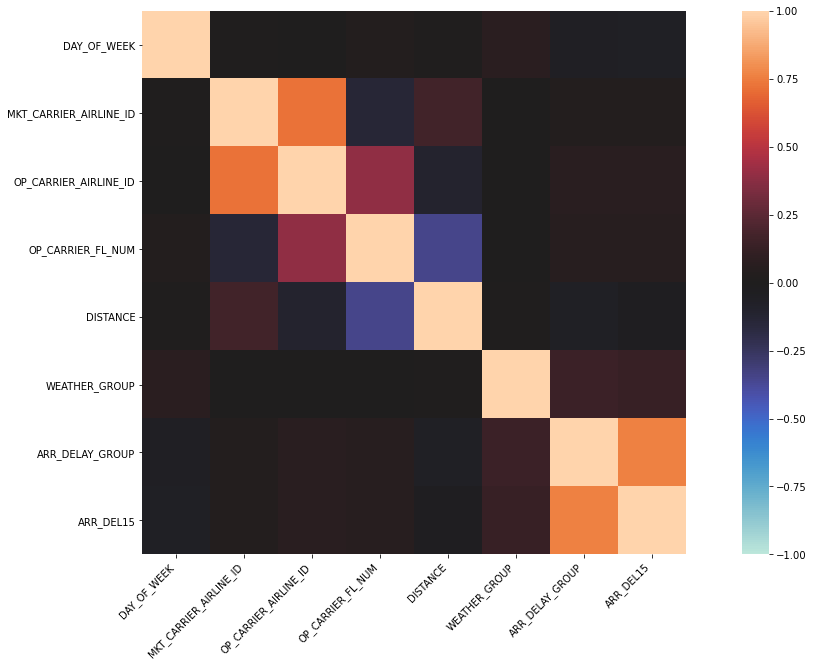

In [119]:
columns =  [column for column in df.columns if column != 'ARR_DELAY_GROUP' and column != 'ARR_DEL15'] + ['ARR_DELAY_GROUP', 'ARR_DEL15']
df = df[columns]
corr=df.corr()
ax = sns.heatmap(corr, 
    vmin=-1, vmax=1, center=0,
    square=True)
ticks = ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')

### The distribution of ARR_DELAY_GROUP

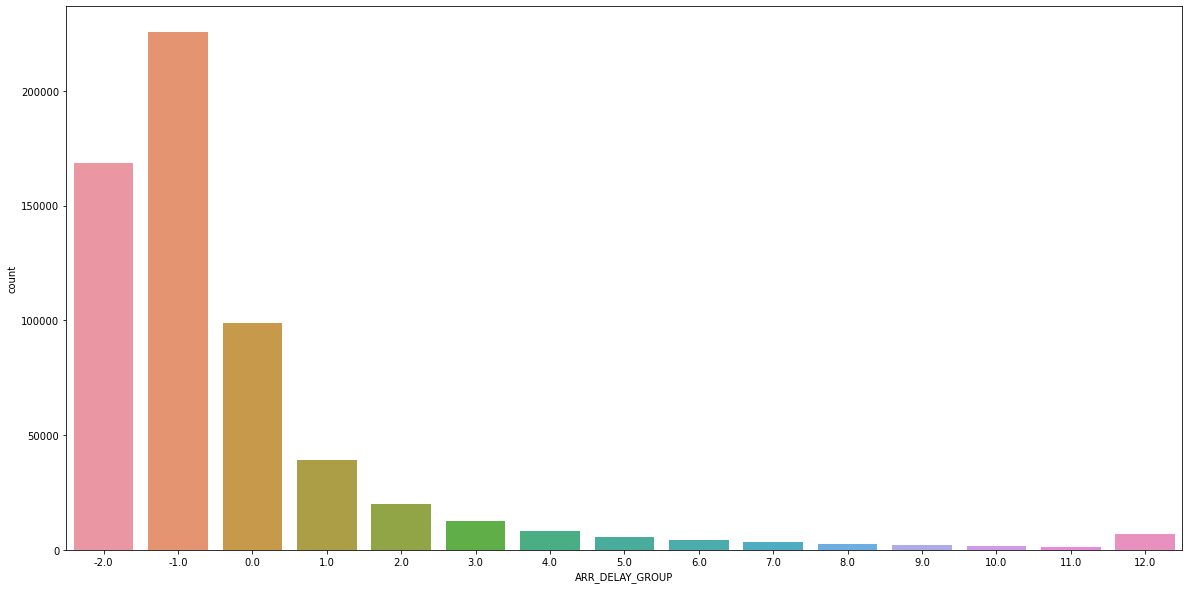

In [120]:
sns.countplot(data = df, x='ARR_DELAY_GROUP')

## We will encode all of the categorical features we are left with using ordinal encoding rather than one-hot encoding, because the labels are too many for that.
Since we are interested in delays we will treat early flights (ARR_DELAY_GROUP = -1 | ARR_DELAY_GROUP = -2) as on-time (ARR_DELAY_GROUP=0)

In [121]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
le= LabelEncoder()
df['MKT_UNIQUE_CARRIER'] = le.fit_transform(df['MKT_UNIQUE_CARRIER'])
df['BRANDED_CODE_SHARE'] = le.fit_transform(df['BRANDED_CODE_SHARE'])
df['MKT_CARRIER_AIRLINE_ID'] = le.fit_transform(df['MKT_CARRIER_AIRLINE_ID'])
df['MKT_CARRIER'] = le.fit_transform(df['MKT_CARRIER'])
df['OP_CARRIER_FL_NUM'] = le.fit_transform(df['OP_CARRIER_FL_NUM'])
df['OP_UNIQUE_CARRIER'] = le.fit_transform(df['OP_UNIQUE_CARRIER'])
df['DEST'] = le.fit_transform(df['DEST'])
df['OP_CARRIER_AIRLINE_ID'] = le.fit_transform(df['OP_CARRIER_AIRLINE_ID'])
df['OP_CARRIER'] = le.fit_transform(df['OP_CARRIER'])
df['TAIL_NUM'] = le.fit_transform(df['TAIL_NUM'].astype(str))
df['ORIGIN'] = le.fit_transform(df['ORIGIN'])

df['ARR_DELAY_GROUP'] = df['ARR_DELAY_GROUP'].replace(-2,0)
df['ARR_DELAY_GROUP'] = df['ARR_DELAY_GROUP'].replace(-1,0)
df.head()

,DAY_OF_WEEK,MKT_UNIQUE_CARRIER,BRANDED_CODE_SHARE,MKT_CARRIER_AIRLINE_ID,MKT_CARRIER,OP_UNIQUE_CARRIER,OP_CARRIER_AIRLINE_ID,OP_CARRIER,TAIL_NUM,OP_CARRIER_FL_NUM,ORIGIN,DEST,DISTANCE,WEATHER_GROUP,ARR_DELAY_GROUP,ARR_DEL15
1,7,3,6,2,3,0,13,0,1255,3462,94,254,453.0,2,0.0,0.0
2,7,3,6,2,3,0,13,0,1190,3464,42,173,187.0,2,0.0,0.0
3,7,3,6,2,3,0,13,0,4662,3467,54,173,184.0,2,0.0,0.0
4,7,3,6,2,3,0,13,0,1278,3468,260,191,335.0,2,0.0,0.0
5,7,3,6,2,3,0,13,0,1278,3469,191,226,812.0,2,0.0,0.0


## We still have three different features all indicating the carrier, we will keep the one that gives us the most variety.

In [122]:
print(f'MKT_UNIQUE_CARRIER unique values: {len(df.MKT_UNIQUE_CARRIER.unique())}\n\
MKT_CARRIER unique values: {len(df.MKT_CARRIER.unique())}\n\
BRANDED_CODE_SHARE unique values: {len(df.BRANDED_CODE_SHARE.unique())}')

MKT_UNIQUE_CARRIER unique values: 11
MKT_CARRIER unique values: 11
BRANDED_CODE_SHARE unique values: 16


In [123]:
df = df.drop(['MKT_UNIQUE_CARRIER', 'MKT_CARRIER', 'OP_CARRIER_AIRLINE_ID'], axis=1)

In [124]:
print(f'OP_UNIQUE_CARRIER unique values: {len(df.OP_UNIQUE_CARRIER.unique())}\n\
OP_CARRIER unique values: {len(df.OP_CARRIER.unique())}')
df = df.drop(['OP_UNIQUE_CARRIER'], axis=1)

OP_UNIQUE_CARRIER unique values: 28
OP_CARRIER unique values: 28


## Finally here're the features upon which our model will be built

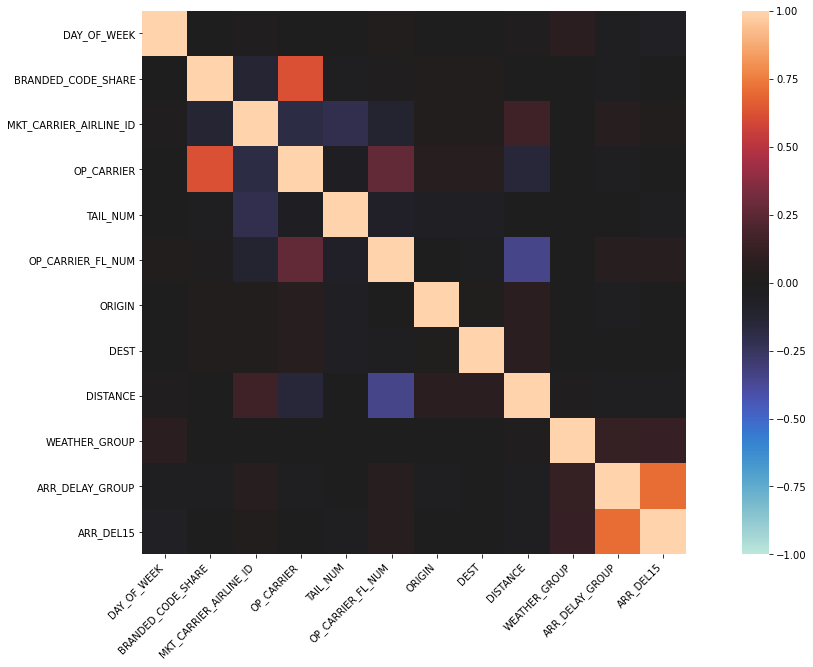

In [125]:
corr=df.corr()
ax = sns.heatmap(corr, 
    vmin=-1, vmax=1, center=0,
    square=True)
ticks = ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')

## We will experiment with ARR_DELAY_GROUP as the target feature

In [126]:
from sklearn.model_selection import train_test_split
from sklearn import metrics
columns = df.columns.tolist()
y=df[['ARR_DELAY_GROUP']]
X=df[columns[:-2]]
columns = X.columns
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [127]:
from sklearn.tree import DecisionTreeClassifier
clf = DecisionTreeClassifier(max_features= 'auto')
clf = clf.fit(X_train,y_train)
y_pred = clf.predict(X_test)
score=metrics.accuracy_score(y_test, y_pred)
print(score)

0.6998136005059414


In [128]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.85      0.84      0.84     98704
         1.0       0.09      0.10      0.10      7800
         2.0       0.06      0.07      0.06      3990
         3.0       0.04      0.05      0.05      2423
         4.0       0.03      0.04      0.03      1665
         5.0       0.02      0.03      0.02      1196
         6.0       0.02      0.03      0.03       851
         7.0       0.03      0.04      0.03       645
         8.0       0.01      0.01      0.01       515
         9.0       0.02      0.02      0.02       430
        10.0       0.02      0.02      0.02       295
        11.0       0.02      0.02      0.02       285
        12.0       0.09      0.10      0.09      1373

    accuracy                           0.70    120172
   macro avg       0.10      0.10      0.10    120172
weighted avg       0.71      0.70      0.71    120172



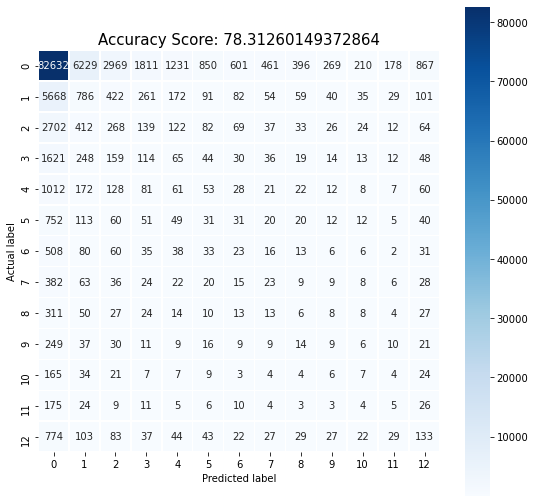

In [143]:
from sklearn.metrics import confusion_matrix
def confusion(y_pred, y_test = y_test):
    confusionMatrix = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(9,9))
    sns.heatmap(confusionMatrix, annot=True, fmt="d", linewidths=.5, square = True, cmap = 'Blues');
    plt.ylabel('Actual label');
    plt.xlabel('Predicted label');
    all_sample_title = 'Accuracy Score: {0}'.format(score*100)
    plt.title(all_sample_title, size = 15)
    
confusion(y_pred)

## We have extremely low f1-scores due to low precision and recall. Our features are just not robust enough to predict delay groups when they are divided into 15-minute intervals.
### We will experiment with one-hour intervals instead

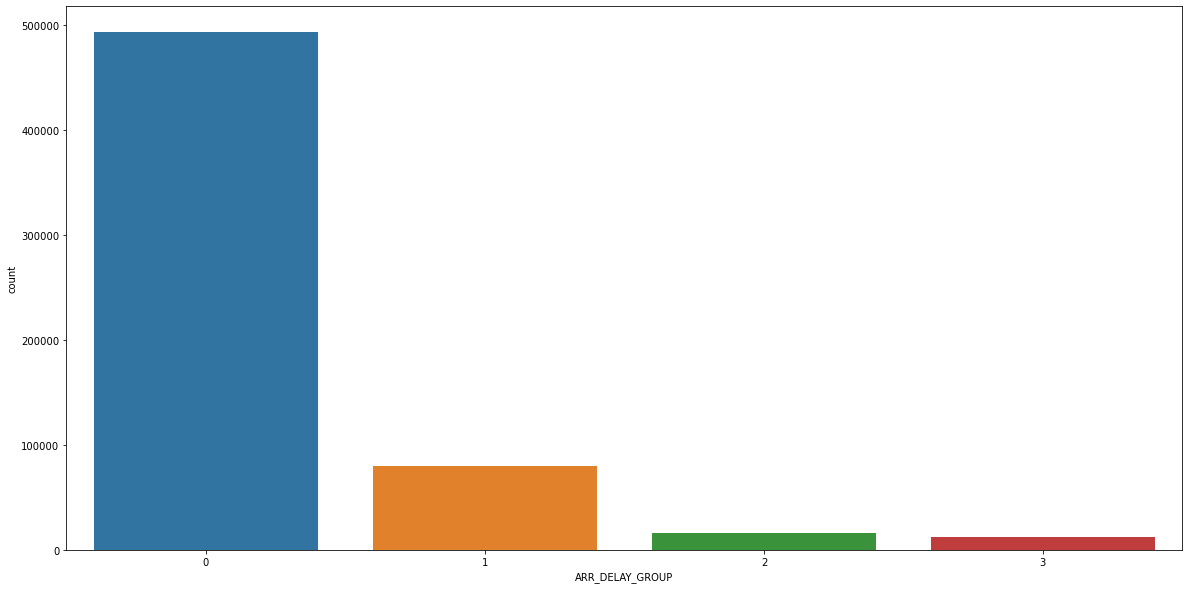

In [28]:
listy = [[1,2,3,4], [5,6,7,8], [9,10,11,12]]
def relabelizer(arr_group):
    for index, i in enumerate(listy):
        if arr_group in i:
            return index+1
    return 0
df['ARR_DELAY_GROUP'] = df.ARR_DELAY_GROUP.apply(relabelizer)
        
sns.countplot(data = df, x='ARR_DELAY_GROUP')

In [29]:
y=df[['ARR_DELAY_GROUP']]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [30]:
clf = DecisionTreeClassifier(max_features= 'auto')
clf = clf.fit(X_train,y_train)
y_pred = clf.predict(X_test)
score=metrics.accuracy_score(y_test, y_pred)
print(score)

0.7259844223279965


In [31]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.85      0.84      0.85     98641
           1       0.21      0.23      0.22     15811
           2       0.10      0.10      0.10      3288
           3       0.13      0.13      0.13      2432

    accuracy                           0.73    120172
   macro avg       0.32      0.33      0.32    120172
weighted avg       0.73      0.73      0.73    120172



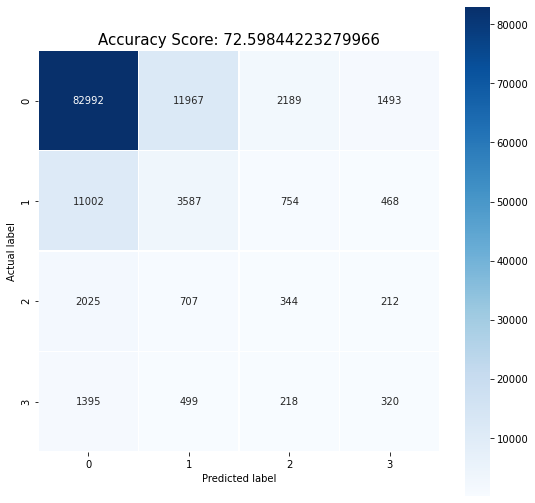

In [32]:
confusion(y_pred)

## Although f1 scores are improved, we don't think they are good enough.
## We wondered if the model was biased because our classes are highly imbalanced, to investigate further we used SMOTE one of the most highly utilized upsampling techniques.

In [33]:
from imblearn.over_sampling import SMOTE
SMOTE = SMOTE()
columns = X_train.columns
X_train_upsampled ,y_train_upsampled=SMOTE.fit_sample(X_train, y_train)
X_train_upsampled = pd.DataFrame(data=X_train_upsampled,columns=columns )
y_train_upsampled = pd.DataFrame(data=y_train_upsampled,columns=['ARR_DELAY_GROUP'])

Using TensorFlow backend.


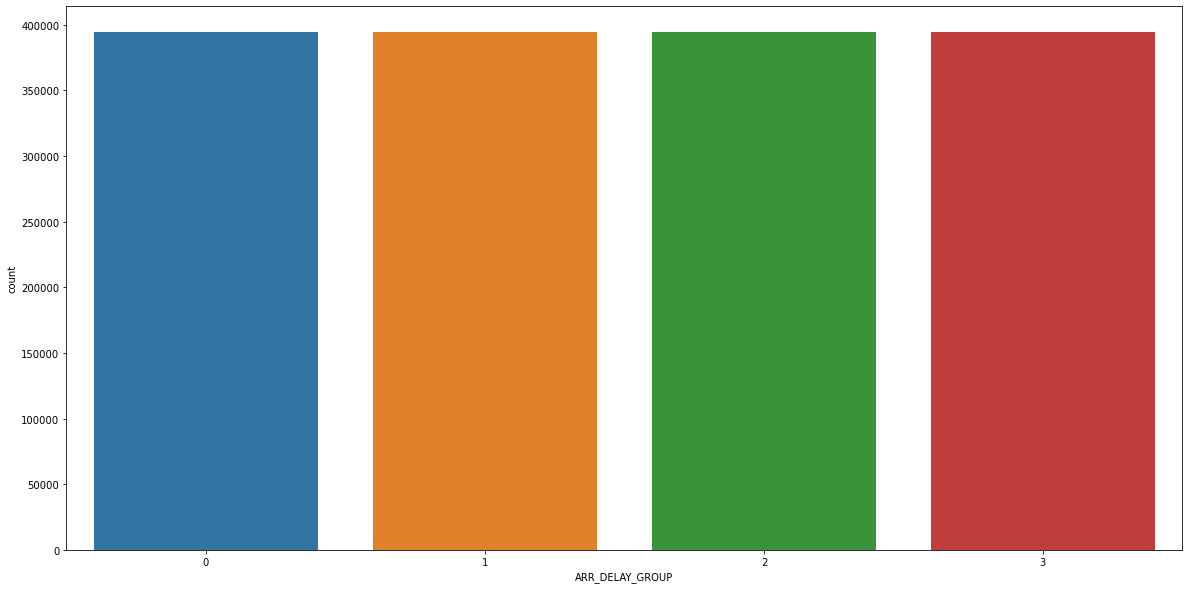

In [34]:
sns.countplot(data = y_train_upsampled, x='ARR_DELAY_GROUP')

In [35]:
clf_upsampled = DecisionTreeClassifier(max_features= 'auto')
clf_upsampled = clf_upsampled.fit(X_train_upsampled,y_train_upsampled)
y_pred_upsampled = clf_upsampled.predict(X_test)
score=metrics.accuracy_score(y_test, y_pred_upsampled)
print(score)

0.6600039942748727


In [36]:
print(classification_report(y_test, y_pred_upsampled))

              precision    recall  f1-score   support

           0       0.86      0.75      0.80     98641
           1       0.19      0.27      0.22     15811
           2       0.07      0.12      0.09      3288
           3       0.09      0.16      0.11      2432

    accuracy                           0.66    120172
   macro avg       0.30      0.33      0.31    120172
weighted avg       0.73      0.66      0.69    120172



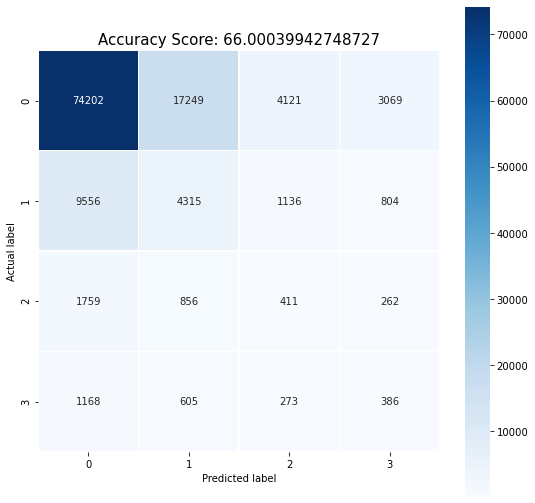

In [37]:
confusion(y_pred_upsampled)

### We got worse results after upsampling.
## Thus We decided to drop ARR_DELAY_GROUP and use ARR_DEL15 as the target feature where all flights with less than 15 minutes of delay are considered on-time and all flights 15 minutes or more late are considered late.

In [38]:
y=df[['ARR_DEL15']]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [39]:
clf = DecisionTreeClassifier(max_features= 'auto')
clf = clf.fit(X_train,y_train)
y_pred = clf.predict(X_test)
score=metrics.accuracy_score(y_test, y_pred)
print(score)

0.7506407482608262


In [40]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.85      0.84      0.85     98453
         1.0       0.32      0.33      0.32     21719

    accuracy                           0.75    120172
   macro avg       0.58      0.59      0.58    120172
weighted avg       0.75      0.75      0.75    120172



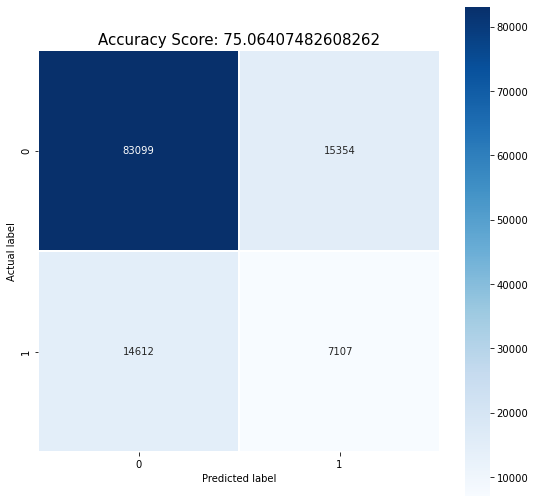

In [41]:
confusion(y_pred)

## This model is producing better results already. We try to find the best decision tree model by fine tuning the models hyper-parameters using N-Fold Cross Validation (N = 20)
### We will optimize the f1 score since our data is imbalanced and optimizing accuracy can lead to models that are not very useful in predicting delayed flights (the less dominant class)

In [42]:
from sklearn.model_selection import RandomizedSearchCV

param_grid = { 'criterion':['gini','entropy'],'max_depth': range(3, 16), 'splitter' : ['best', 'random'], 'max_features' : ['auto', 'sqrt', 'log2']}
clf=DecisionTreeClassifier()
random_search = RandomizedSearchCV(clf, param_grid, cv=20,scoring='f1_macro', n_iter = 25, n_jobs = -1, verbose=1)
random_search.fit(X_train, y_train)
random_search.best_params_

Fitting 20 folds for each of 25 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    4.9s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:   26.2s
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:   56.0s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:  1.1min finished


{'splitter': 'best',
 'max_features': 'auto',
 'max_depth': 15,
 'criterion': 'entropy'}

In [48]:
best_decision_tree = DecisionTreeClassifier(splitter = 'best', max_features = 'auto', max_depth = 15, criterion = 'entropy')
best_decision_tree = best_decision_tree.fit(X_train,y_train)
y_pred = best_decision_tree.predict(X_test)
score=metrics.accuracy_score(y_test, y_pred)
print(score)

0.8164297839763006


In [49]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.83      0.98      0.90     98453
         1.0       0.44      0.06      0.11     21719

    accuracy                           0.82    120172
   macro avg       0.63      0.52      0.50    120172
weighted avg       0.76      0.82      0.75    120172



[[96779  1674]
 [20386  1333]]


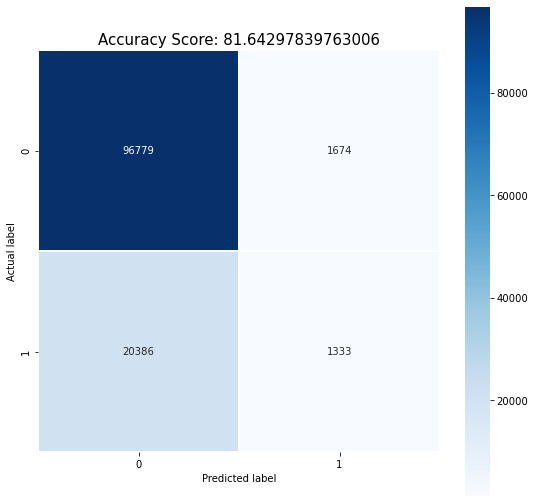

In [50]:
confusion(y_pred)

## Below are the features' importances according to the best model we found

In [51]:
feature_importance = {key:value for key, value in zip(columns, best_decision_tree.feature_importances_)}
feature_importance

{'DAY_OF_WEEK': 0.13170839813397006,
 'BRANDED_CODE_SHARE': 0.02109007264657825,
 'MKT_CARRIER_AIRLINE_ID': 0.049771079416121924,
 'OP_CARRIER': 0.029514125466025276,
 'TAIL_NUM': 0.13691907120339158,
 'OP_CARRIER_FL_NUM': 0.15716339759260095,
 'ORIGIN': 0.09129882735080987,
 'DEST': 0.09247046544775808,
 'DISTANCE': 0.09364924917985948,
 'WEATHER_GROUP': 0.19641531356288455}

## We will build a random forest model by bagging N decision trees with the best paramaters that we arrived at
We will use randomized grid search optimize N and class_weight. Optimizing for f1 score.

In [89]:
from sklearn.ensemble import RandomForestClassifier
param_grid = {'n_estimators': [10,25,50,100], 'criterion': ['entropy'], 'max_depth': [15], 'max_features' : ['auto'], 'class_weight' : ['balanced', 'balanced_subsample', None]}
clf=RandomForestClassifier()
random_search = RandomizedSearchCV(clf, param_grid, cv=20,scoring='f1_macro',  n_iter = 25, n_jobs = -1, verbose=1)
random_search.fit(X_train, y_train)
random_search.best_params_

Fitting 20 folds for each of 12 candidates, totalling 240 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed: 20.8min
[Parallel(n_jobs=-1)]: Done 240 out of 240 | elapsed: 30.8min finished


{'n_estimators': 100,
 'max_features': 'auto',
 'max_depth': 15,
 'criterion': 'entropy',
 'class_weight': 'balanced'}

In [90]:
best_random_forest = RandomForestClassifier(n_estimators = 100, max_depth = 15, criterion = 'entropy', max_features = 'auto', class_weight = 'balanced')
best_random_forest = best_random_forest.fit(X_train,y_train)
y_pred = best_random_forest.predict(X_test)
score=metrics.accuracy_score(y_test, y_pred)
print(score)

0.6943381153679725


In [91]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.89      0.71      0.79     98453
         1.0       0.32      0.61      0.42     21719

    accuracy                           0.69    120172
   macro avg       0.61      0.66      0.61    120172
weighted avg       0.79      0.69      0.73    120172



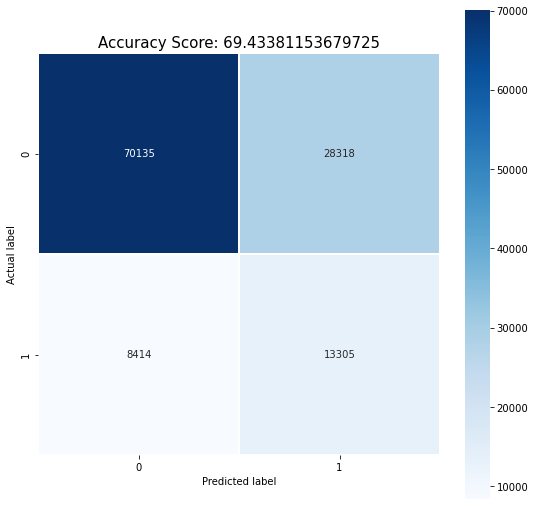

In [92]:
confusion(y_pred)

## The random forest model has a lower overall accuracy since it was optimized for f1 score. it is a compromise but the upside of it is that this model can predict delayed flights (positive class) much more effictively.

In [93]:
feature_importance = {key:value for key, value in zip(columns, best_random_forest.feature_importances_)}
feature_importance

{'DAY_OF_WEEK': 0.10446396919372256,
 'BRANDED_CODE_SHARE': 0.02637030799598083,
 'MKT_CARRIER_AIRLINE_ID': 0.03362284924258278,
 'OP_CARRIER': 0.040320242762056986,
 'TAIL_NUM': 0.14642303627928607,
 'OP_CARRIER_FL_NUM': 0.1646618197328362,
 'ORIGIN': 0.10448205152045516,
 'DEST': 0.10416439640616633,
 'DISTANCE': 0.11317610859591756,
 'WEATHER_GROUP': 0.16231521827099554}

# Now we will process Jan 2019 data in exactly the same way

In [130]:
df_2029 = pd.read_csv("Data_jan_2019.csv")
df_2029=df_2029.drop(['SCH_OP_UNIQUE_CARRIER', 'SCH_OP_CARRIER_AIRLINE_ID','SCH_OP_CARRIER','SCH_OP_CARRIER_FL_NUM'], axis=1)
weather_df_2029 = df_2029.groupby('FL_DATE').agg({'WEATHER_DELAY':'mean'}).reset_index()
weather_dict = {}
for weather_group, quantile in enumerate(np.arange(0.2, 1.01, .2)):
    weather_dict[weather_group] = np.quantile(weather_df_2029.WEATHER_DELAY, quantile)
weather_dict
weather_df_2029['WEATHER_GROUP'] = 0
for index, row in weather_df_2029.iterrows():
    for weather_group in range(0,5):
        if row['WEATHER_DELAY'] < weather_dict[weather_group]:
            weather_df_2029.loc[index, 'WEATHER_GROUP'] = weather_group
            break
        if weather_group == 4:
            weather_df_2029.loc[index, 'WEATHER_GROUP'] = 4

weather_df_2029['WEATHER_GROUP'].value_counts()
weather_df_2029 = weather_df_2029.drop(['WEATHER_DELAY'], axis=1)
df_2029 = df_2029.merge(weather_df_2029)
columns_to_remove = [column for column in df_2029.columns if ('ARR_DEL' in column or 'DEP_DEL' in column or 'DELAY' in column) and column != 'ARR_DELAY_GROUP' and column != 'ARR_DEL15']
columns_to_remove = columns_to_remove +['FLIGHTS','CANCELLED','MKT_CARRIER_FL_NUM','YEAR', 'FL_DATE', 'DEST_CITY_NAME', 'ORIGIN_CITY_NAME']
columns_to_remove
df_2029 = df_2029[df_2029.CANCELLED == 0]
df_2029=df_2029.drop(columns_to_remove, axis=1)
df_2029=df_2029.dropna(subset=['ARR_DEL15'])
columns =  [column for column in df_2029.columns if column != 'ARR_DELAY_GROUP' and column != 'ARR_DEL15'] + ['ARR_DELAY_GROUP', 'ARR_DEL15']
df_2029 = df_2029[columns]
le= LabelEncoder()
df_2029['MKT_UNIQUE_CARRIER'] = le.fit_transform(df_2029['MKT_UNIQUE_CARRIER'])
df_2029['BRANDED_CODE_SHARE'] = le.fit_transform(df_2029['BRANDED_CODE_SHARE'])
df_2029['MKT_CARRIER_AIRLINE_ID'] = le.fit_transform(df_2029['MKT_CARRIER_AIRLINE_ID'])
df_2029['MKT_CARRIER'] = le.fit_transform(df_2029['MKT_CARRIER'])
df_2029['OP_CARRIER_FL_NUM'] = le.fit_transform(df_2029['OP_CARRIER_FL_NUM'])
df_2029['OP_UNIQUE_CARRIER'] = le.fit_transform(df_2029['OP_UNIQUE_CARRIER'])
df_2029['DEST'] = le.fit_transform(df_2029['DEST'])
df_2029['OP_CARRIER_AIRLINE_ID'] = le.fit_transform(df_2029['OP_CARRIER_AIRLINE_ID'])
df_2029['OP_CARRIER'] = le.fit_transform(df_2029['OP_CARRIER'])
df_2029['TAIL_NUM'] = le.fit_transform(df_2029['TAIL_NUM'].astype(str))
df_2029['ORIGIN'] = le.fit_transform(df_2029['ORIGIN'])
df_2029 = df_2029.drop(['MKT_UNIQUE_CARRIER', 'MKT_CARRIER', 'OP_CARRIER_AIRLINE_ID'], axis=1)
df_2029 = df_2029.drop(['OP_UNIQUE_CARRIER'], axis=1)
columns = df_2029.columns.tolist()
X_2019=df_2029[columns[:-2]]
y_2019=df_2029[['ARR_DEL15']]

## Validating best_decision_tree on Jan 2019 data

In [135]:
y_predict_2019 = best_decision_tree.predict(X_2019)

In [137]:
score=metrics.accuracy_score(y_2019, y_predict_2019)
print(score)

0.7831260149372864


In [139]:
print(classification_report(y_2019, y_predict_2019))

              precision    recall  f1-score   support

         0.0       0.81      0.95      0.88    500505
         1.0       0.21      0.05      0.08    117144

    accuracy                           0.78    617649
   macro avg       0.51      0.50      0.48    617649
weighted avg       0.70      0.78      0.73    617649



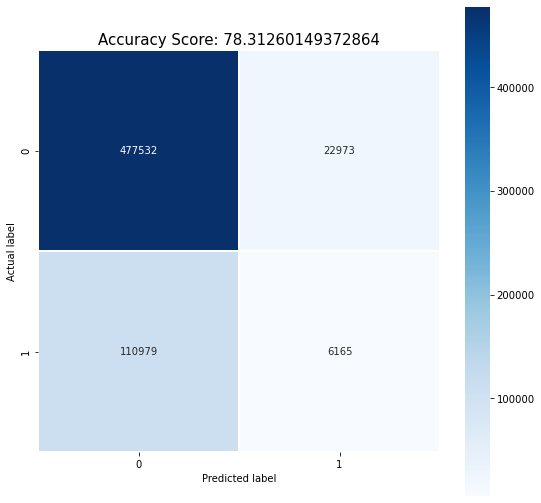

In [144]:
confusion(y_predict_2019, y_2019)

The results are strikingly similar, similar accuracy, similar f1-score and even similar looking confusion matrix

## Validating best_random_forest on Jan 2019 data

In [145]:
y_predict_2019 = best_random_forest.predict(X_2019)

In [146]:
score=metrics.accuracy_score(y_2019, y_predict_2019)
print(score)

0.7042608342278543


In [147]:
print(classification_report(y_2019, y_predict_2019))

              precision    recall  f1-score   support

         0.0       0.83      0.80      0.82    500505
         1.0       0.25      0.28      0.26    117144

    accuracy                           0.70    617649
   macro avg       0.54      0.54      0.54    617649
weighted avg       0.72      0.70      0.71    617649



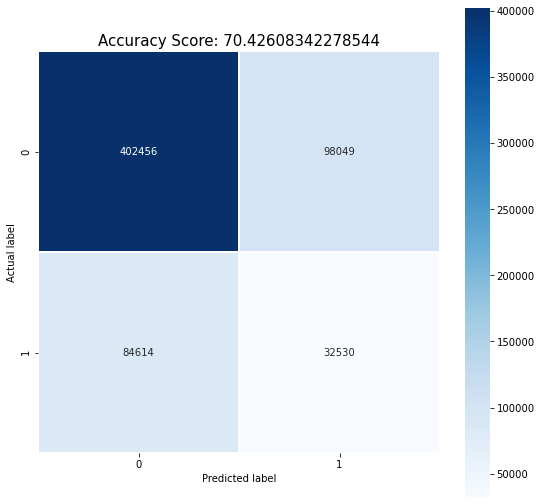

In [148]:
confusion(y_predict_2019, y_2019)

### Similar to before this model produces lower overall accuracy. However it predicts the positive class much more effectively.